In [ ]:
%run ../modules/qpca

<b>General implementation of a Quantum PCA for any size covariance matrices.</b>

In [ ]:
import numpy as np
import scipy
from math import *
from qiskit.visualization import plot_histogram
from scipy.stats import ortho_group

Generation of the covariance matrix and normalization

In [3]:
#number of features
N = 4

data = scipy.random.rand(10,N)*20
means = np.mean(data,axis=0)
u=np.ones(len(data))[None] 
u=u.reshape((len(data),1)) 
means=means.reshape((len(data[0]),1))
centered = data-np.dot(u,means.T)



covmat = np.dot(centered.transpose(),centered)
covmat = covmat/np.trace(covmat)

for r in covmat:
    #print("&".join([str(c.round(4)) for c in r])+"\\")
    pass

eigvals, eigvecs = np.linalg.eig(covmat)
idx = np.argsort(eigvals)
eigvals = eigvals[idx]
eigvecs = eigvecs[:,idx]

In [4]:
for i in range(N):
    print(f"Eigvector associated to {np.round(eigvals[i].real,5)}: [{','.join([str(j.real) for j in np.round(eigvecs.T[i],4)])} ].")

Eigvector associated to 0.03847: [-0.6448,0.0818,-0.2992,-0.6985 ].
Eigvector associated to 0.12152: [0.5062,0.5262,-0.6732,-0.1173 ].
Eigvector associated to 0.25086: [-0.2577,-0.5107,-0.6743,0.4669 ].
Eigvector associated to 0.58916: [0.5114,-0.675,-0.0508,-0.5294 ].


[(0.609375, 1), (0.53125, 1), (0.625, 1), (0.21875, 1), (0.09375, 1), (0.203125, 1), (0.15625, 1), (0.546875, 1), (0.234375, 2), (0.109375, 2), (0.078125, 2), (0.5625, 3), (0.578125, 5), (0.265625, 9), (0.03125, 15), (0.25, 273), (0.046875, 281), (0.59375, 298), (0.125, 302)]
[0.25, 0.046875, 0.59375, 0.125]
Using estimate for 0.25: [ 0.19518001  0.56904264  0.6761234  -0.42538498], with weight: 0.24615384615384617
Using estimate for 0.046875: [ 0.60219379 -0.10482848  0.39223227  0.68740634], with weight: 0.046153846153846156
Using estimate for 0.59375: [ 0.51929079 -0.67872981 -0.         -0.51929079], with weight: 0.5846153846153846
Using estimate for 0.125: [ 0.50251891  0.62764591 -0.58603272 -0.10050378], with weight: 0.12307692307692308


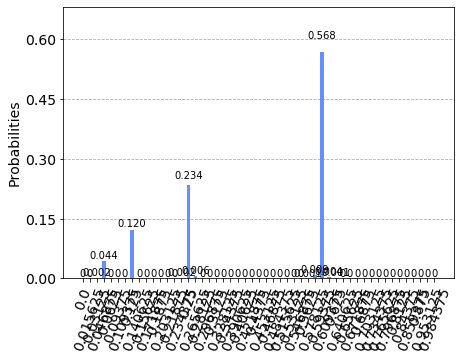

In [5]:
bits = 8
shots_per_vec1 = 100
shots_per_vec2 = 1000
roundoff = 2

pool = ortho_group.rvs(dim=N)
res = None
for i in range(N):
    initial = pool[i]
    if res is None:
        res = qpca(covmat,bits,initial= initial, req_shots = shots_per_vec1, nbitsroundoff = roundoff)
    else:
        res.merge(qpca(covmat,bits,initial= initial, req_shots = shots_per_vec1, nbitsroundoff = roundoff))
        
eigval_occurences = res.get_eigvals()
print(eigval_occurences)

#THRESHOLDING
relevant_eigvals = [i[0] for i in eigval_occurences[-N:]]
print(relevant_eigvals)

eigvec_weights = [i/sum(relevant_eigvals) for i in relevant_eigvals]

result = None
for ev,weight in zip(relevant_eigvals,eigvec_weights):
    initial = res.eigvec_from_eigval(ev)
    print(f"Using estimate for {ev}: {initial}, with weight: {weight}")
    if len(initial)==0:
        continue
    if result is None:
        result = qpca(covmat,bits,initial= initial, req_shots = int(shots_per_vec2*weight*N+1), nbitsroundoff = roundoff)
    else:
        result.merge(qpca(covmat,bits,initial= initial, req_shots = int(shots_per_vec2*weight*N+1), nbitsroundoff = roundoff))

plot_histogram(result.get_eigvals(False))

In [6]:
K = 4

#RETRIEVE EIGVECTORS ESTIMATES
estimated_eigenvalues = sorted(result.get_eigvals()[-K:])
estimated_eigvals = [i[0] for i in estimated_eigenvalues[-K:]]
print("eigenvalues considered ", estimated_eigvals)
eigenvectors = [result.eigvec_from_eigval(i[0]) for i in estimated_eigenvalues]

eigval_diag = np.diag(estimated_eigvals)
estimated_eigvecs = np.array(eigenvectors[-K:]).T

lowrank_covmat_est = np.matmul(np.matmul(estimated_eigvecs,eigval_diag),estimated_eigvecs.T)
lowrank_covmat = np.matmul(np.matmul(eigvecs[:,-K:],np.diag(eigvals[-K:])),eigvecs[:,-K:].T)
diff = lowrank_covmat_est - lowrank_covmat
print("reconstruction error l2 norm ",np.linalg.norm(diff)/np.linalg.norm(lowrank_covmat))

#VECTORS ORTHOGONALITY
U = np.matmul(estimated_eigvecs.T, estimated_eigvecs)
print("vectors orthogonality error ",np.linalg.norm(U - np.eye(K))/K)

eigenvalues considered  [0.046875, 0.125, 0.25, 0.59375]
reconstruction error l2 norm  0.022427531138367672
vectors orthogonality error  0.0069170130092565734


In [407]:
print("eigenvalues: ",estimated_eigvals)
err = 0
for i in range(K):
    v1 = result.eigvec_from_eigval(estimated_eigvals[-i-1])
    v2 = eigvecs[:,-i-1]
    d1 = np.linalg.norm(v1-v2)
    d2 = np.linalg.norm(v2+v1)
    err += d1 if d1 < d2 else d2
err /= K
print("average eigenvector error l2 norm: ",err)

eigenvalues:  [0.09375, 0.140625, 0.203125, 0.484375]
average eigenvector error l2 norm:  0.05461000926180254


In [7]:
print(covmat)

[[ 0.21787962 -0.14003185 -0.00569487 -0.1795744 ]
 [-0.14003185  0.36777937  0.06260797  0.14100805]
 [-0.00569487  0.06260797  0.1741024  -0.04551218]
 [-0.1795744   0.14100805 -0.04551218  0.24023861]]
